## COMP5329 Assignment 2


Members:
1. Zhuoyang Li (480164337)
2. Melissa Tan (200249191)
3. Jimmy Yue   (440159151)

## Instruction to run

1. Change the path to the location where the train & test files resides (in the **Library** and **Extract gz files** section )
2. Click on run all to execute the entire code 


This Notebook is designed to run on GPU. If running Colab, click on the **Runtime** on the menu bar and click on **change runtime type**. Then change hardware accelerator to GPU

# Library


In [0]:
import math, os, sys
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import itertools
from scipy import misc, ndimage
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

import numpy as np
import itertools
import h5py
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

SEED = 42
histories = {}
# for reproducebility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED) # set seed for numoy generated randon mumbers
random.seed(SEED)    # set seed for python random numbers

# file path
FOLDER_ID = '1PPBJhVV5pmBOEzRAS7AgUR1q-rtKxG5W'
LOCAL_PATH = '/content/gdrive/My Drive/tmp/'  # local path to store model as gpu env gets wiped out
LOG_DIR = './log'
TRAIN_PATH = '/home/jupyter/.keras/datasets/train2014'
TEST_PATH = '/home/jupyter/.keras/datasets/test'
LABEL_PATH = '/home/jupyter/.keras/datasets/train.txt'


# training default parameters
BATCH_SIZE = 16
SPLIT = 0.4  # test/validation split
EPOCH = 25
WORKER = 4
LR = 0.00001  # learning rate
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) # height, width, 3 RGB channel


# Setup

In [0]:
# for drawing network diagram
!pip install pydot graphviz
!pip install pydot3 pydot-ng

  Using cached https://files.pythonhosted.org/packages/33/d1/b1479a770f66d962f545c2101630ce1d5592d90cb4f083d38862e93d16d2/pydot-1.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1f/e2/ef2581b5b86625657afd32030f90cf2717456c1d2b711ba074bf007c0f1a/graphviz-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3c/5b/9a08333f2d70d404ffe42cea4f50159c4ad94feaa4d7585551c05cacef46/pydot_ng-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/51/f45cea425fd5cb0b0380f5b0f048ebc1da5b417e48d304838c02d6288a1e/setuptools-41.0.1-py2.py3-none-any.whl


## Setup Tensor Board on colab

In [0]:
# https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

#  fire up the TensorBoard in the background like this:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
    
# Clear any logs from previous runs
!rm -rf ./log/ 

--2019-05-30 21:34:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.53.176, 52.203.66.95, 35.172.177.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.53.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  15.88M  20.2MB/s    in 0.8s    

2019-05-30 21:34:54 (20.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
https://45169934.ngrok.io


## Check GPU

In [0]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Fri May 31 01:43:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Functions

## Plot Acc v Loss

In [0]:
# Function to view accuracy & loss chart
def plotResult(model, model_name):
    trainAcc = model.history['acc']
    valAcc = model.history['val_acc']

    trainLoss = model.history['loss']
    valLoss = model.history['val_loss']

    epochs = range(len(trainAcc))
    plt.figure(figsize=(12,6))
    plt.plot(epochs, trainAcc, 'b', label='training acc')
    plt.plot(epochs, valAcc, 'r', label='validation acc')

    bestEpoch = np.argmin(model.history["val_loss"])
    bestAcc = trainAcc[bestEpoch]
    bestValAcc = valAcc[bestEpoch]
    minTrainLoss = trainLoss[bestEpoch]
    minValLoss = valLoss[bestEpoch]

    print(model_name)
    print('bestEpoch | bestAcc | bestValAcc : ', bestEpoch , ' | ' , bestAcc , ' | ' , bestValAcc)
    print('minTrainLoss | minValLoss : ', minTrainLoss, ' | ' , minValLoss)
    
    plt.plot(bestEpoch, bestValAcc, marker="x", color="r", label="best model")
    #plt.title('Training and validation accuracy ' + model_name)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    
    plt.legend()

    plt.figure(figsize=(12,6))

    plt.plot(epochs, trainLoss, 'steelblue', label='Training loss')
    plt.plot(epochs, valLoss, 'tomato', label='Validation loss')
    plt.plot( np.argmin(model.history["val_loss"]), np.min(model.history["val_loss"]), 
             marker="x", color="tomato", label="best model")

    #plt.title('Training and validation loss ' + model_name)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    
    plt.legend()

    plt.show()


## Plot Image

In [0]:
def plotImg(ims, figsize=(12,6), rows=1, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if ims.shape[-1] != 3:
      ims = ims.transpose((0,2,3,1))
      
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else lens(ims)//rows + 1
  
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

## Metrics
Supposed {2,10} is the ground truth . 

Then {2}, {10}, {2, 10}, {10, 2} are all right answers, if you give one of them, you will get the full score. Others are wrong answers.

### Custom function

In [0]:
import keras.backend as K

def acc_threshold(y_true, y_pred_prob, threshold=0.5):
      # requires specify threshold
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.convert_to_tensor(y_pred_prob > threshold)

    # use bitwise operator. 1&1=1, 0&1=0, 1&0=0, 0&0=0. Therefore the result will return 1 if both actual & pred are 1
    correct = tf.math.logical_and(y_true, y_pred, name='correct') 
    incorrect = tf.subtract( tf.cast(correct, tf.int8), tf.cast(y_pred, tf.int8), name='incorrect')
    reduced = tf.reduce_sum(incorrect, axis=1) 
    total_wrong = tf.shape(tf.boolean_mask(incorrect, reduced))[0]
    total_record = tf.shape(y_true)[0]
    total_correct = total_record - total_wrong
    acc = tf.math.divide( total_correct , total_record  ) 
    return acc

Using TensorFlow backend.


## Callback

In [0]:
#! ls -al ./log
#! rm -r ./log

In [0]:
def callbacks(filename):
    return [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', verbose=1),
    #tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filename, verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR + '/'+ filename)
    ]



# File IO

The below extract the zip files from GCP bucket. Note bucket may **NO** longer be available after 31 May 2019 as it is a paid storage.

## Extract gz from GCP

Extract from Google Cloud Platform bucket

In [0]:
# frm GCp bucket
def extractFile():


    import pathlib
    data_root = tf.keras.utils.get_file(fname='train',
                                        origin='https://storage.googleapis.com/dlcomp5329/train.tar.gz', 
                                        untar=True)
    data_root = pathlib.Path(data_root)

    data_root = tf.keras.utils.get_file(fname='test',
                                        origin='https://storage.googleapis.com/dlcomp5329/test.tar.gz', 
                                        untar=True)
    data_root = pathlib.Path(data_root)
    
    data_root = tf.keras.utils.get_file(fname='train.txt',
                                    origin='https://storage.googleapis.com/dlcomp5329/train.txt', 
                                    untar=False)
    data_root = pathlib.Path(data_root)

    print(data_root)
    
    ! mkdir -p /home/jupyter/.keras/datasets/test/
    ! mv /home/jupyter/.keras/datasets/val2014 /home/jupyter/.keras/datasets/test/val2014

## Extract gz files from google drive

In [0]:
def extractFile(folderId):
    !pip install -U -q PyDrive 

    # read from google drive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    local_download_path = os.path.expanduser('~/data')

    try:
      os.makedirs(local_download_path)
    except: pass

    file_list = drive.ListFile(
        {'q': "'" + folderId + "' in parents"}).GetList()
    
    # list files
    for f in file_list:
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(local_download_path, f['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)

    # create directories. 
    # -p: make parent directories if not exist
    !mkdir -p /content/train/
    !mkdir -p /content/test/
    
    # untar file into /content/
    # x: This option tells tar to extract the files.
    # v: The “v” stands for “verbose.” This option will list all of the files one by one in the archive.
    # z: The z option is very important and tells the tar command to uncompress the file (gzip).
    # f: This options tells tar that you are going to give it a file name to work with.
    !tar xvzf /root/data/train.tar.gz -C /content/train/
    !tar xvzf /root/data/test.tar.gz  -C /content/test/
    
    # move train.txt file to train directory
    !mv /root/data/train.txt /content/train/train.txt



## Create Data Generator



1.   simple -  rescaled image without transformations
2.   augmented - rescaled image tranformed through shifting, zooming, rotation, flipping and etc to prevent overfitting and helps the model generalize better.

In [0]:
# Original images consist in RGB (0-255) but the values would be too high for our models to process (given a typical learning rate), so we scale with a 1/255 factor
# Create a second data generator to augment data. Data augmentation is one way to fight overfitting, but it isn't enough since augmented samples are still highly correlated.

def createDataGen(split=0.2):
    dataGens = {}

  # simple gen
    tmp = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=split,
      rescale=1./255)
  
    dataGens['simple'] = tmp
  
  # augmented
    tmp = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=split,
      rotation_range=40,       # rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
      rescale=1./255,          
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height))
      fill_mode='nearest')     # strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift
  
    dataGens['augmented'] = tmp

    return dataGens


## Data Pipeline -Train & Test


In [0]:
def loadData(datagen, path, df, classes, batchSize, seed):
    t = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path,
        subset='training',     # training 
        x_col='filename',      # column of dataframe that contain image filename
        y_col=classes,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode="other",
        target_size=IMAGE_SIZE)

    v = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path,
        subset='validation',   # validation
        x_col='filename',      # column of dataframe that contain image filename
        y_col=classes,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode="other",
        target_size=IMAGE_SIZE)

    return (t,v)


def loadTestData(path, batchSize, seed):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
  
    return datagen.flow_from_directory(
        directory=path,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode=None,  # generator will only yield batches of data without labels
        target_size=IMAGE_SIZE)




## Data Pipeline -  Label

In [0]:
import pandas as pd

def loadTrainLabel(path):
    with open(path, 'rb') as f:
        lines = [x.decode('utf8').strip('').strip('\n') for x in f.readlines()]
        trainY = np.zeros((len(lines), 20))

    for row, line in enumerate(lines):
        labels = line.split('\t')[1].split(',')

        # read training labels and do one hot encode
        for col in labels:
            trainY[row, int(col)] = 1


    df = pd.DataFrame(trainY)
    df['filename'] = df.index.values.astype(str)
    df['filename'] = df.apply(lambda x: x.filename +'.jpg', axis=1)
    return df

# Load Data

In [0]:
# one off extract process to unzip files and place in correct directory
extractFile('11bT7FFLq-zD517gtLfTYVtZceiOE-772');
#extractFile();

# load train label 
trainY_df = loadTrainLabel(LABEL_PATH)
classes = trainY_df.columns[:-1]
print(trainY_df.shape)
print(trainY_df.head())

# create various data genenrator. ie basic & augmented
dataGens = createDataGen(split=SPLIT)


TRAIN_COUNT = len(os.listdir(TRAIN_PATH))
TRAIN_STEP_SIZE = math.floor(TRAIN_COUNT/BATCH_SIZE) * (1-SPLIT)
VALID_STEP_SIZE = math.floor(TRAIN_COUNT/BATCH_SIZE) * SPLIT


(31925, 21)
     0    1    2    3    4    5    6    7    8    9  ...   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   

    15   16   17   18   19  filename  
0  0.0  0.0  0.0  1.0  0.0     0.jpg  
1  0.0  0.0  0.0  0.0  1.0     1.jpg  
2  0.0  0.0  0.0  0.0  0.0     2.jpg  
3  0.0  0.0  0.0  0.0  0.0     3.jpg  
4  0.0  0.0  0.0  0.0  0.0     4.jpg  

[5 rows x 21 columns]


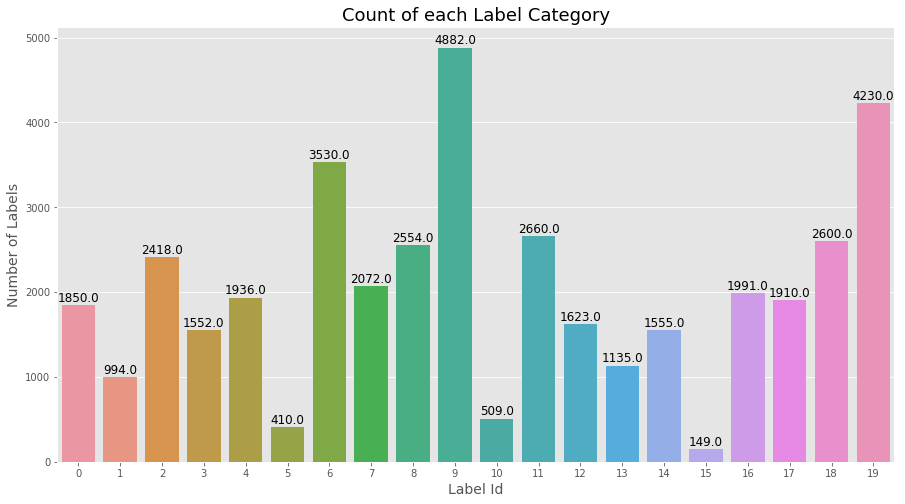

In [0]:
data_raw = trainY_df.iloc[:,0:-1]
categories = list(data_raw.columns.values)

plt.figure(figsize=(15,8))
ax = sns.barplot(categories, data_raw.sum().values)
plt.title("Count of each Label Category", fontsize=18)
plt.ylabel('Number of Labels', fontsize=14)
plt.xlabel('Label Id', fontsize=14)

#adding the text labels
rects = ax.patches
labels = data_raw.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

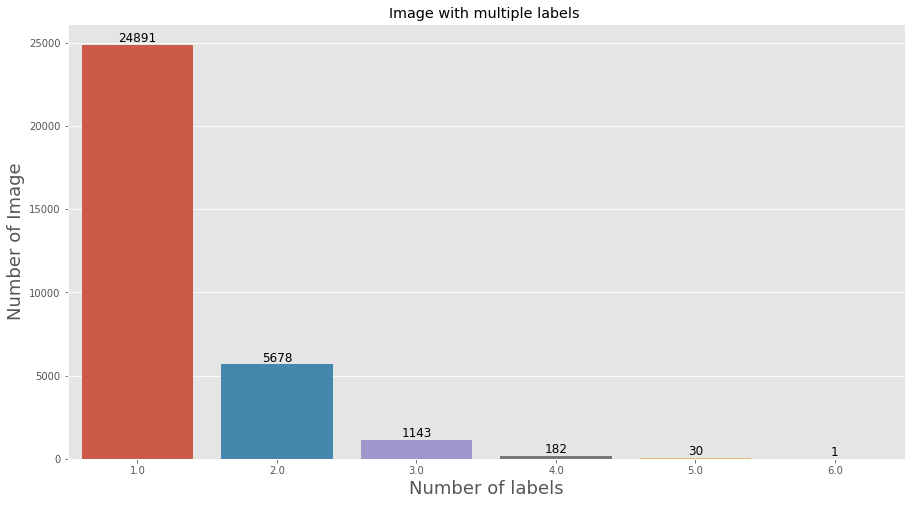

In [0]:
rowSums = data_raw.sum(axis=1)
multiLabel_counts = rowSums.value_counts()

plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Image with multiple labels ")
plt.ylabel('Number of Image', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

# Simple Model

In [0]:
def simple(inputShape, nb_classes, lr, decay, param):
    model =  tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    if param['BatchNormalization'] == True:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if param['DropoutYN'] == True:
        model.add(tf.keras.layers.Dropout(param['Dropout']))
  
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    if param['BatchNormalization'] == True:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if param['DropoutYN'] == True:
        model.add(tf.keras.layers.Dropout(param['Dropout']))
  
  # fully-connected layers
    model.add(tf.keras.layers.Flatten()) # convert 3D feature maps to 1D feature vectors
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
    if param['BatchNormalization'] == True:
        model.add(tf.keras.layers.BatchNormalization())
    if param['DropoutYN'] == True:
        model.add(tf.keras.layers.Dropout(param['Dropout']))
    model.add(tf.keras.layers.Dense(len(nb_classes), activation=param['activation']))
    
    model.compile(tf.keras.optimizers.Adam(lr=LR, decay=decay), 
                loss=param['loss'], metrics=param['metrics'])
    return model



# Train

In [0]:
def TrainSimple(model_name, param, datagen, lr, decay, cb):
    trainGen, valGen = loadData(datagen=dataGens[datagen], path=TRAIN_PATH, 
                              df=trainY_df, classes=classes, 
                              batchSize=BATCH_SIZE, seed=SEED)

  
    # define model
    model = simple(INPUT_SHAPE, classes, lr=lr, decay=decay, param=param)

    # save pretty model diagram
    keras.utils.plot_model(model, model_name + '.png', show_shapes=True)

    # fit model
    history = model.fit_generator(
          generator = trainGen,
          steps_per_epoch = trainGen.n//trainGen.batch_size,
          validation_data = valGen,
          validation_steps = valGen.n//valGen.batch_size,
          workers=WORKER,
          epochs = EPOCH,
          callbacks = cb,
          )

    # save model
    model.save_weights(model_name + '_weights.h5')
    model.save(model_name + '.h5')
    return history

## Simple BinaryE with Sigmoid

In [0]:
# define parameters
param = {'activation':'sigmoid', 'loss':'binary_crossentropy', 'metrics': ["accuracy"] , 'BatchNormalization' :True , 'DropoutYN' :False , 'Dropout' : 0.5}
model_name = 'CNN_simple'
early_stopping = [keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', verbose=0)]
history = TrainSimple(model_name, param, 'simple', lr=0.001, decay=1e-6, cb=early_stopping)
histories[model_name] = history

Found 19155 images.
Found 12770 images.
Epoch 1/25
1198/1198 [==============================] - 208s 174ms/step - loss: 0.7086 - acc: 0.5580 - val_loss: 0.6685 - val_acc: 0.6072
Epoch 2/25
1198/1198 [==============================] - 207s 173ms/step - loss: 0.6205 - acc: 0.6808 - val_loss: 0.6339 - val_acc: 0.6633
Epoch 3/25
1198/1198 [==============================] - 206s 172ms/step - loss: 0.5462 - acc: 0.7758 - val_loss: 0.6027 - val_acc: 0.7024
Epoch 4/25
1198/1198 [==============================] - 209s 174ms/step - loss: 0.4510 - acc: 0.8615 - val_loss: 0.5074 - val_acc: 0.7864
Epoch 5/25
1198/1198 [==============================] - 205s 171ms/step - loss: 0.3623 - acc: 0.9227 - val_loss: 0.4756 - val_acc: 0.8043
Epoch 6/25
1198/1198 [==============================] - 207s 173ms/step - loss: 0.2921 - acc: 0.9585 - val_loss: 0.3898 - val_acc: 0.8621
Epoch 7/25
1198/1198 [==============================] - 208s 173ms/step - loss: 0.2231 - acc: 0.9843 - val_loss: 0.3561 - val_acc: 0

CNN_simple
bestEpoch | bestAcc | bestValAcc :  11  |  0.99973357  |  0.92799884
minTrainLoss | minValLoss :  0.042767445795399435  |  0.22594074431214672


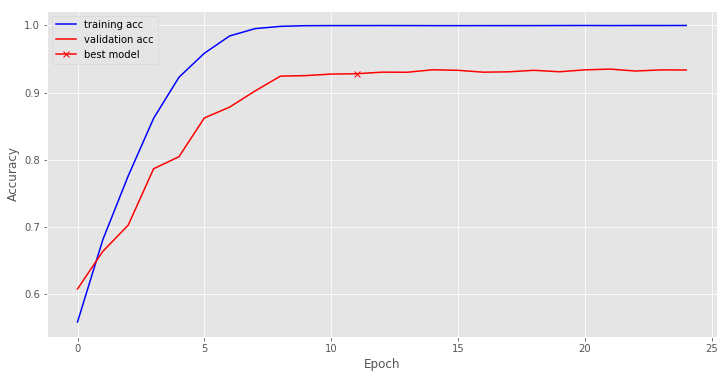

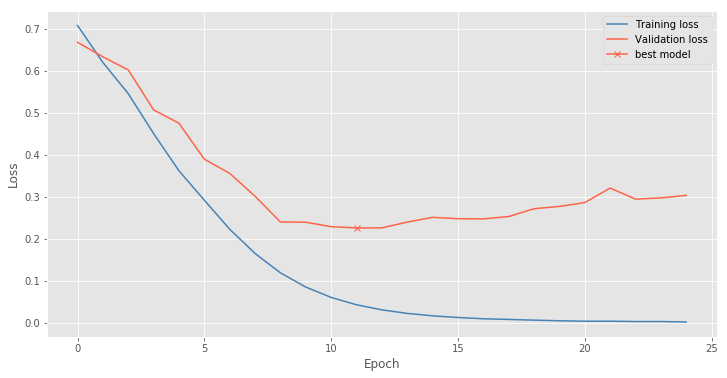

In [0]:
plotResult(history, model_name)

## Simple BinaryE with Sigmoid (augmented data)

In [0]:
# define parameters
param = {'activation':'sigmoid', 'loss':'binary_crossentropy', 'metrics': ["accuracy"] , 'BatchNormalization' :True , 'DropoutYN' :False , 'Dropout' : 0.5}
model_name = 'cnn_augmented'
early_stopping = [keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', verbose=0)]
history = TrainSimple(model_name, param, 'augmented', lr=0.001, decay=1e-6, cb=early_stopping)
histories['cnn_augmented'] = history

Found 19155 images.
Found 12770 images.
Epoch 1/25
1198/1198 [==============================] - 364s 304ms/step - loss: 0.7026 - acc: 0.5664 - val_loss: 0.6628 - val_acc: 0.6327
Epoch 2/25
1198/1198 [==============================] - 364s 304ms/step - loss: 0.6387 - acc: 0.6901 - val_loss: 0.6160 - val_acc: 0.7496
Epoch 3/25
1198/1198 [==============================] - 364s 304ms/step - loss: 0.5892 - acc: 0.8005 - val_loss: 0.5572 - val_acc: 0.8401
Epoch 4/25
1198/1198 [==============================] - 367s 306ms/step - loss: 0.5277 - acc: 0.8710 - val_loss: 0.4948 - val_acc: 0.8903
Epoch 5/25
1198/1198 [==============================] - 363s 303ms/step - loss: 0.4585 - acc: 0.9089 - val_loss: 0.4178 - val_acc: 0.9216
Epoch 6/25
1198/1198 [==============================] - 364s 304ms/step - loss: 0.3903 - acc: 0.9271 - val_loss: 0.3596 - val_acc: 0.9292
Epoch 7/25
1198/1198 [==============================] - 364s 304ms/step - loss: 0.3313 - acc: 0.9334 - val_loss: 0.3035 - val_acc: 0

cnn_augmented
bestEpoch | bestAcc | bestValAcc :  21  |  0.9395253  |  0.9372905
minTrainLoss | minValLoss :  0.17278656836932646  |  0.18367238913444764


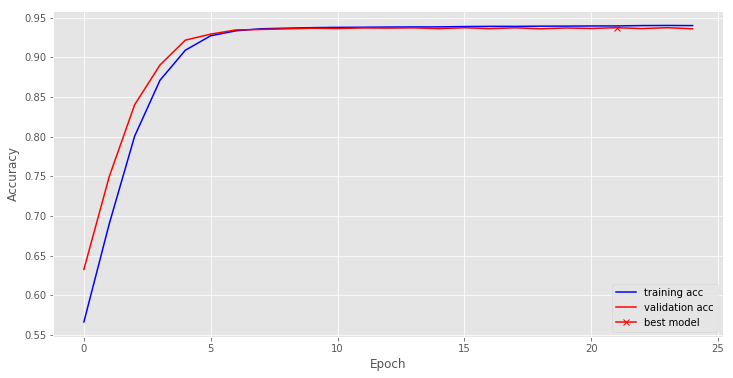

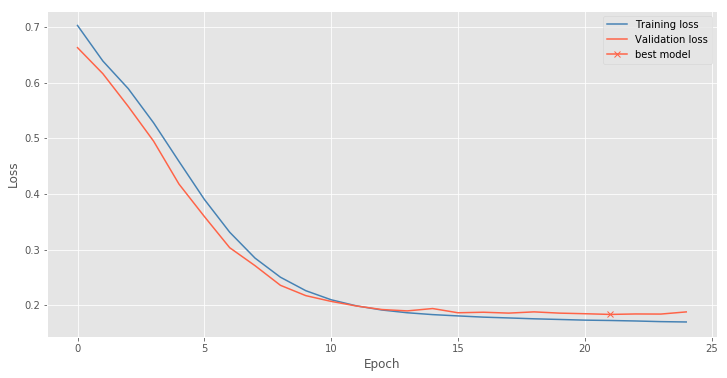

In [0]:
plotResult(history, model_name)

## Find best learning rate

Found 19155 images.
Found 12770 images.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
1198/1198 [==============================] - 250s 209ms/step - loss: 0.8891 - acc: 0.5158 - acc_threshold: 0.0000e+00 - val_loss: 2.0671 - val_acc: 0.6275 - val_acc_threshold: 0.0000e+00
Epoch 2/25
1198/1198 [==============================] - 249s 208ms/step - loss: 0.8235 - acc: 0.5299 - acc_threshold: 0.0000e+00 - val_loss: 2.4732 - val_acc: 0.5977 - val_acc_threshold: 1.5645e-04
Epoch 3/25
1198/1198 [==============================] - 249s 208ms/step - loss: 0.8029 - acc: 0.5400 - acc_threshold: 0.0000e+00 - val_loss: 2.5647 - val_acc: 0.5927 - val_acc_threshold: 7.8223e-05
Epoch 4/25
1198/1198 [==============================] - 250s 209ms/step - loss: 0.7872 - acc: 0.5471 - acc_threshold: 0.0000e+00 - 

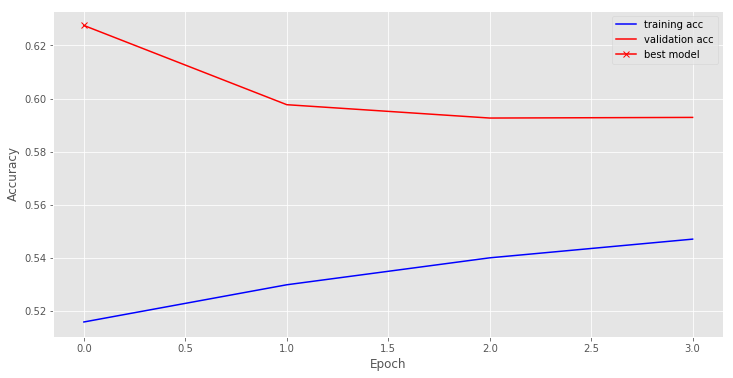

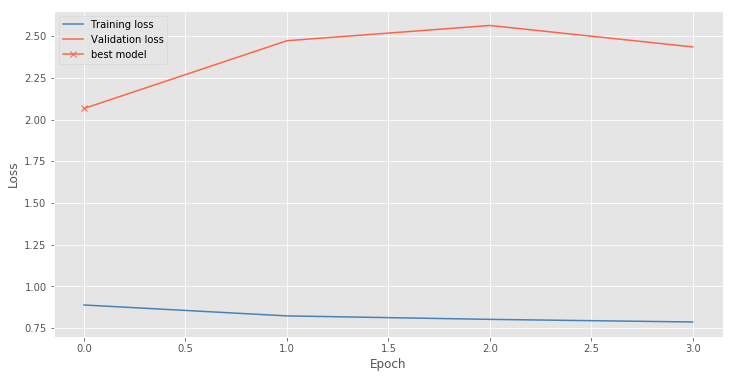

Found 19155 images.
Found 12770 images.
Epoch 1/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.8845 - acc: 0.5148 - acc_threshold: 0.0000e+00 - val_loss: 1.9183 - val_acc: 0.6719 - val_acc_threshold: 0.0023
Epoch 2/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.8204 - acc: 0.5287 - acc_threshold: 0.0000e+00 - val_loss: 2.1662 - val_acc: 0.6486 - val_acc_threshold: 0.0021
Epoch 3/25
1198/1198 [==============================] - 249s 208ms/step - loss: 0.7997 - acc: 0.5380 - acc_threshold: 0.0000e+00 - val_loss: 2.0873 - val_acc: 0.6524 - val_acc_threshold: 0.0069
Epoch 4/25
1198/1198 [==============================] - 249s 208ms/step - loss: 0.7897 - acc: 0.5446 - acc_threshold: 0.0000e+00 - val_loss: 2.0605 - val_acc: 0.6487 - val_acc_threshold: 0.0077
cnn_Augmented_lr_1e-05_dc0.001
bestEpoch | bestAcc | bestValAcc :  0  |  0.5147828  |  0.67193425
minTrainLoss | minValLoss :  0.884318334376087  |  1.9183076288882126


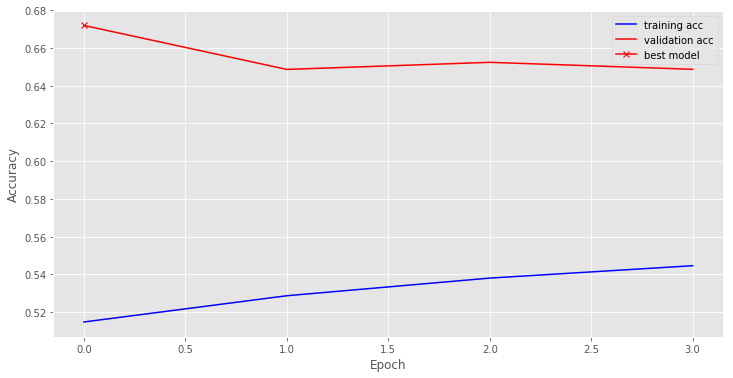

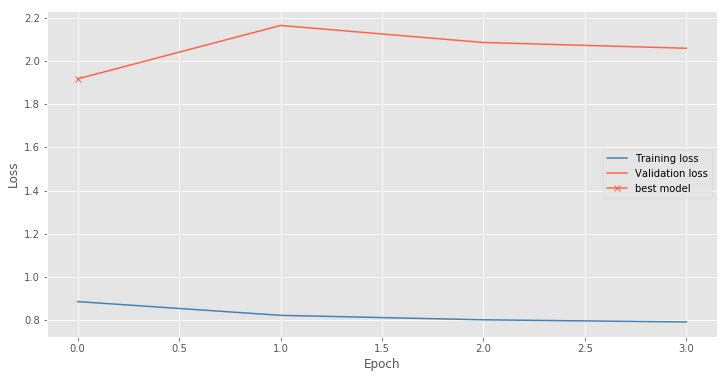

Found 19155 images.
Found 12770 images.
Epoch 1/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.8672 - acc: 0.5204 - acc_threshold: 0.0000e+00 - val_loss: 2.4994 - val_acc: 0.6417 - val_acc_threshold: 0.0000e+00
Epoch 2/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.7847 - acc: 0.5498 - acc_threshold: 0.0000e+00 - val_loss: 2.3199 - val_acc: 0.6579 - val_acc_threshold: 1.5645e-04
Epoch 3/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.7310 - acc: 0.5893 - acc_threshold: 3.6519e-04 - val_loss: 2.2534 - val_acc: 0.6519 - val_acc_threshold: 0.0042
Epoch 4/25
1198/1198 [==============================] - 246s 206ms/step - loss: 0.6678 - acc: 0.6429 - acc_threshold: 0.0017 - val_loss: 1.6575 - val_acc: 0.7437 - val_acc_threshold: 0.0659
Epoch 5/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.5884 - acc: 0.7132 - acc_threshold: 0.0163 - val_loss: 1.6429 - val_acc: 0.7717 - val_acc_threshol

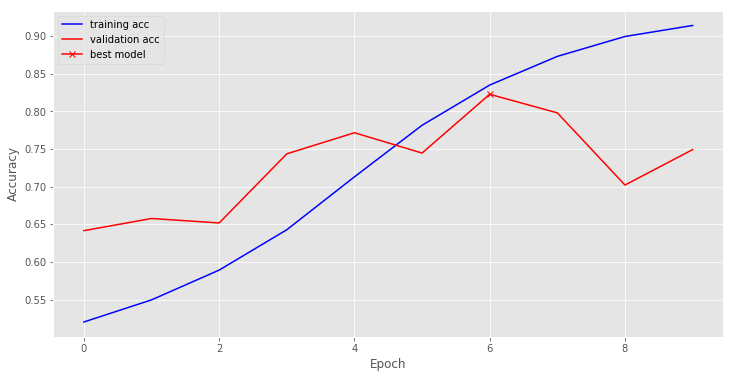

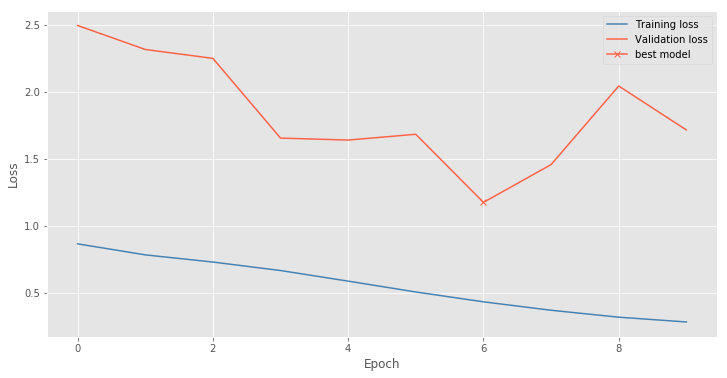

Found 19155 images.
Found 12770 images.
Epoch 1/25
1198/1198 [==============================] - 250s 209ms/step - loss: 0.8763 - acc: 0.5202 - acc_threshold: 0.0000e+00 - val_loss: 1.8119 - val_acc: 0.6534 - val_acc_threshold: 6.2578e-04
Epoch 2/25
1198/1198 [==============================] - 250s 208ms/step - loss: 0.7901 - acc: 0.5505 - acc_threshold: 1.0434e-04 - val_loss: 2.1212 - val_acc: 0.6646 - val_acc_threshold: 0.0076
Epoch 3/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.7369 - acc: 0.5900 - acc_threshold: 1.0434e-04 - val_loss: 1.6163 - val_acc: 0.7091 - val_acc_threshold: 0.0310
Epoch 4/25
1198/1198 [==============================] - 248s 207ms/step - loss: 0.6754 - acc: 0.6451 - acc_threshold: 0.0030 - val_loss: 1.2117 - val_acc: 0.7773 - val_acc_threshold: 0.1479
Epoch 5/25
1198/1198 [==============================] - 249s 207ms/step - loss: 0.5998 - acc: 0.7200 - acc_threshold: 0.0224 - val_loss: 1.1490 - val_acc: 0.8136 - val_acc_threshold: 0

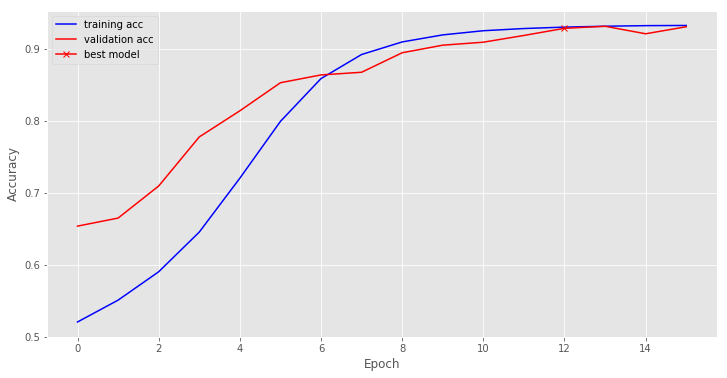

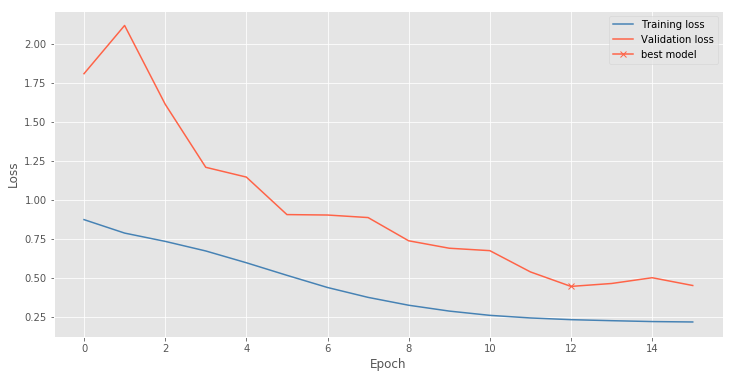

In [0]:
lr = [1e-3, 1e-5]
decay = [1e-3,1e-6]
early_stopping = [keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', verbose=0)]
  
for dc in decay:
  for i in lr:
    # define parameters
      param = {'activation':'sigmoid', 'loss':'binary_crossentropy', 'metrics': ["accuracy", acc_threshold] , 'BatchNormalization' :True , 'DropoutYN' :True, 'Dropout': 0.5 }
      model_name = param['activation'] + '_' + param['loss'] + '_BN_Dropout:' + str(param['Dropout'] )

      history = TrainSimple(model_name, param, 'augmented', lr=i, decay=dc, cb=early_stopping)
      histories['cnn_Augmented_lr_' + str(i) + '_dc' + str(dc)] = history
      plotResult(history, 'cnn_Augmented_lr_' + str(i) + '_dc' + str(dc))
    

Training Accurancy


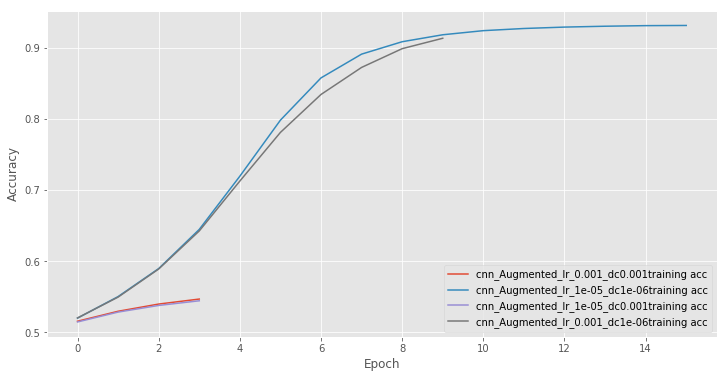

Validation Accurancy


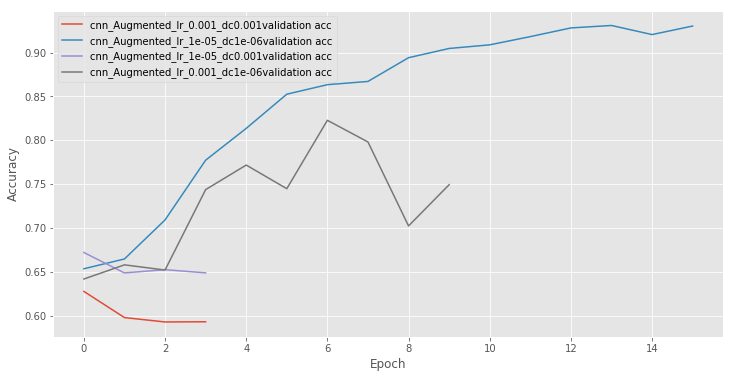

Training Loss


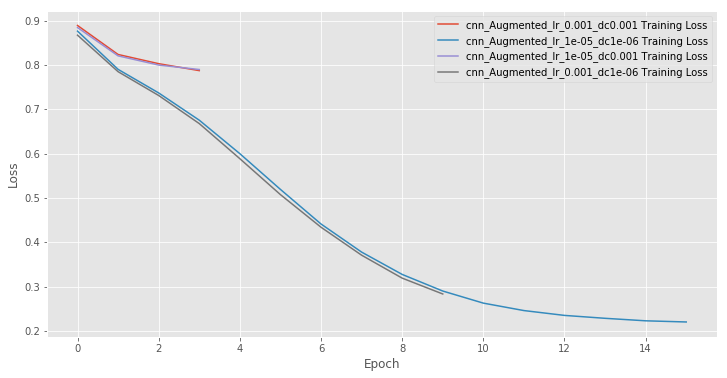

Validation Loss


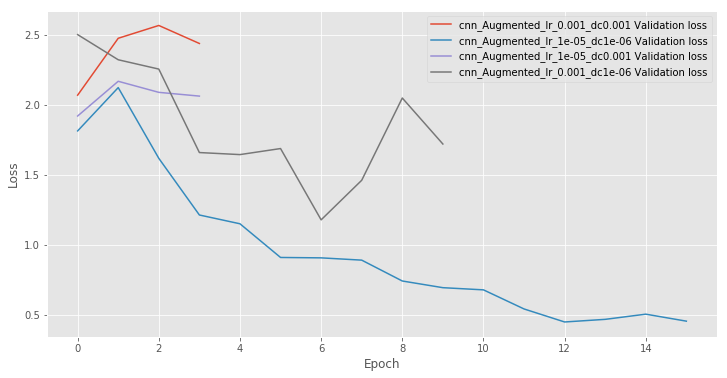

In [0]:
plt.figure(figsize=(12,6))
# Accuracy Benchmark    
print('Training Accurancy')
for key, val in histories.items():
  
  trainAcc = val.history['acc']
  epochs = range(len(trainAcc))
  
  plt.plot(epochs, trainAcc,  label=key +'training acc')

plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
# Validation Benchmark
print('Validation Accurancy')
for key, val in histories.items():
  valAcc = val.history['val_acc']
  epochs = range(len(valAcc))
  plt.plot(epochs, valAcc,  label=key +'validation acc')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()
  

  
  
# Training Loss Benchmark  
plt.figure(figsize=(12,6))
print('Training Loss')
for key, val in histories.items():
  trainLoss = val.history['loss']
  epochs = range(len(trainLoss))
  plt.plot(epochs, trainLoss, label=key+' Training Loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()


# Validation Loss Benchmark  
print('Validation Loss')
plt.figure(figsize=(12,6))
for key, val in histories.items():
  valLoss = val.history['val_loss']
  epochs = range(len(valLoss))
  plt.plot(epochs, valLoss, label=key+' Validation loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()
    

## Test various Drop out rate and BN

Found 19155 images.
Found 12770 images.
Epoch 1/25
799/799 [==============================] - 132s 165ms/step - loss: 1.5329 - acc: 0.5765

Epoch 00001: val_loss improved from inf to 1.53285, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.2callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 371s 310ms/step - loss: 0.7529 - acc: 0.5343 - val_loss: 1.5329 - val_acc: 0.5765
Epoch 2/25
799/799 [==============================] - 129s 161ms/step - loss: 1.3705 - acc: 0.6200

Epoch 00002: val_loss improved from 1.53285 to 1.37045, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.2callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 367s 306ms/step - loss: 0.6885 - acc: 0.5861 - val_loss: 1.3705 - val_acc: 0.6200
Epoch 3/25
799/799 [==============================] - 128s 160ms/step - loss: 1.4440 - acc: 0.6645

Epoch 00003: val_loss did not improve from

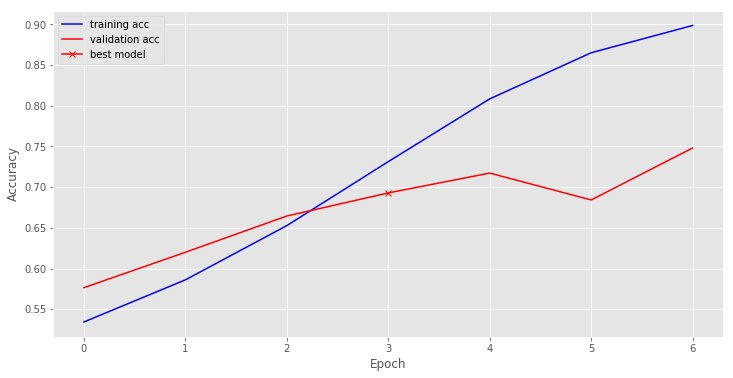

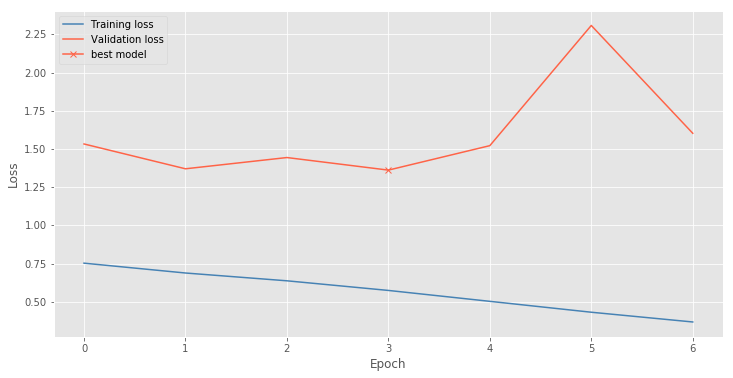

Found 19155 images.
Found 12770 images.
Epoch 1/25
799/799 [==============================] - 125s 157ms/step - loss: 2.3803 - acc: 0.5675

Epoch 00001: val_loss improved from inf to 2.38032, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.3callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 358s 299ms/step - loss: 0.7787 - acc: 0.5306 - val_loss: 2.3803 - val_acc: 0.5675
Epoch 2/25
799/799 [==============================] - 128s 160ms/step - loss: 2.2395 - acc: 0.6082

Epoch 00002: val_loss improved from 2.38032 to 2.23950, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.3callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 364s 304ms/step - loss: 0.7089 - acc: 0.5757 - val_loss: 2.2395 - val_acc: 0.6082
Epoch 3/25
799/799 [==============================] - 125s 157ms/step - loss: 1.5573 - acc: 0.6688

Epoch 00003: val_loss improved from 2.2395

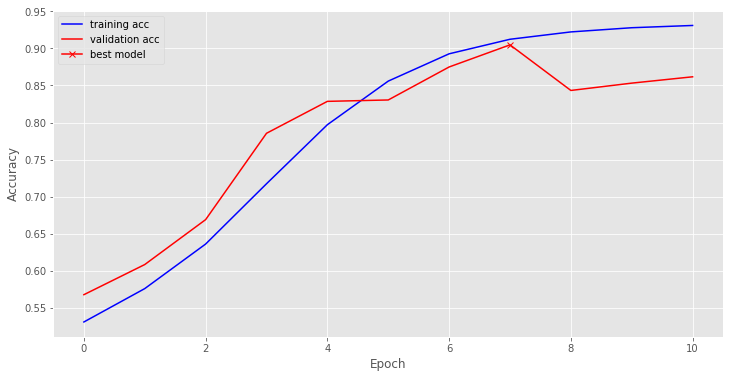

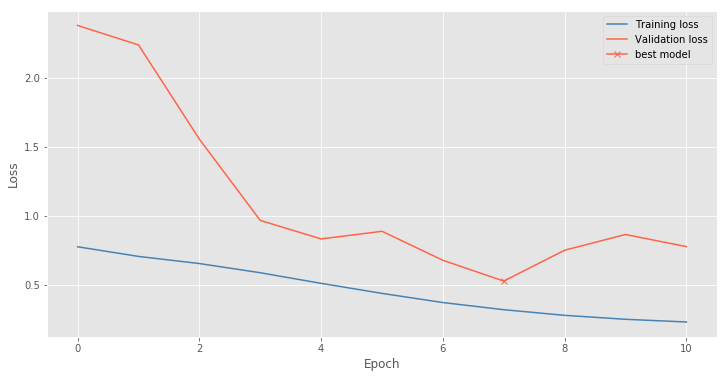

Found 19155 images.
Found 12770 images.
Epoch 1/25
799/799 [==============================] - 130s 163ms/step - loss: 1.5097 - acc: 0.5888

Epoch 00001: val_loss improved from inf to 1.50968, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.4callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 373s 311ms/step - loss: 0.8208 - acc: 0.5223 - val_loss: 1.5097 - val_acc: 0.5888
Epoch 2/25
799/799 [==============================] - 131s 163ms/step - loss: 1.4901 - acc: 0.6200

Epoch 00002: val_loss improved from 1.50968 to 1.49011, saving model to sigmoid_binary_crossentropy_BN_Dropout:0.4callbacks.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 371s 310ms/step - loss: 0.7456 - acc: 0.5583 - val_loss: 1.4901 - val_acc: 0.6200
Epoch 3/25
799/799 [==============================] - 130s 163ms/step - loss: 1.2730 - acc: 0.6699

Epoch 00003: val_loss improved from 1.4901

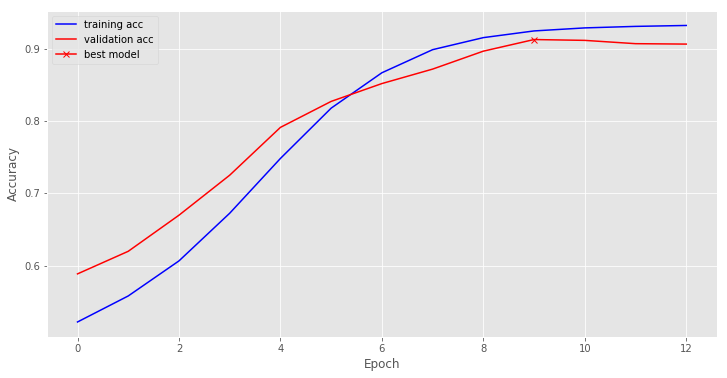

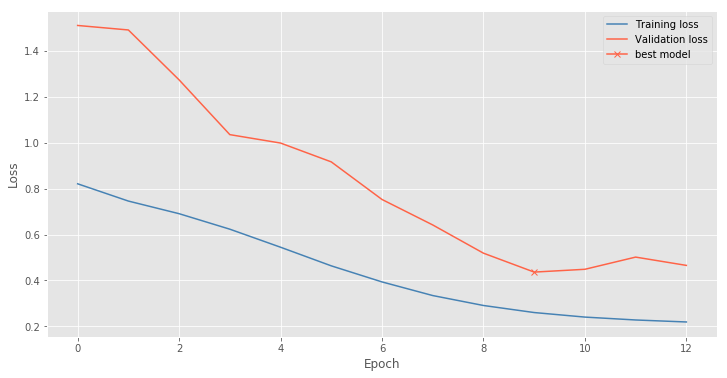

In [0]:
do = [0.2, 0.3, 0.4]
lr = 1e-3
decay =  1e-6


for i in do:
  # define parameters
    param = {'activation':'sigmoid', 'loss':'binary_crossentropy', 'metrics': ["accuracy"] , 'BatchNormalization' :True , 'DropoutYN' :True, 'Dropout': i }
    model_name = param['activation'] + '_' + param['loss'] + '_BN_Dropout:' + str(param['Dropout'] )
    cb = callbacks(model_name + 'callbacks.hd5')
    history = TrainSimple(model_name, param, 'augmented', lr=lr, decay=decay, cb=cb)
    histories['cnn_Augmented_do_' + str(i)] = history
    plotResult(history, 'cnn_Augmented_do_' + str(i))

In [0]:
import csv
# save history  as csv just in case

w = csv.writer(open("histories.csv", "w"))
for key, val in histories.items():
    w.writerow(key)
    print(key)
    print(key, val.history['loss'])
    print(key, val.history['val_loss'])
    print(key, val.history['acc'])
    print(key, val.history['val_acc'])
    
    
    w.writerow([key+'_loss', val.history['loss']])
    w.writerow([key+'_val_loss', val.history['val_loss']])
    w.writerow([key+'_acc', val.history['acc']])
    w.writerow([key+'_val_acc', val.history['val_acc']])
    

# Results

CNN_simple
bestEpoch | bestAcc | bestValAcc :  11  |  0.99973357  |  0.92799884
minTrainLoss | minValLoss :  0.042767445795399435  |  0.22594074431214672


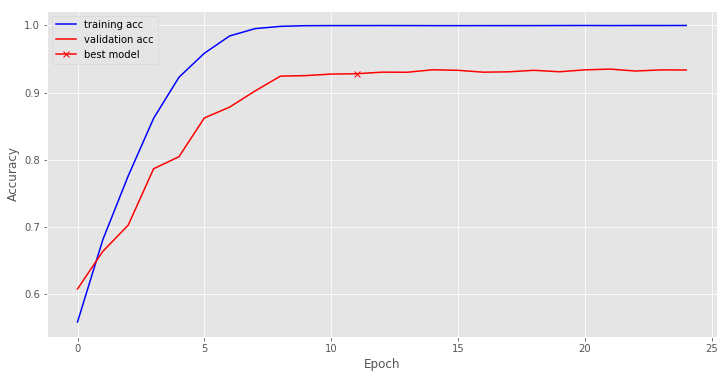

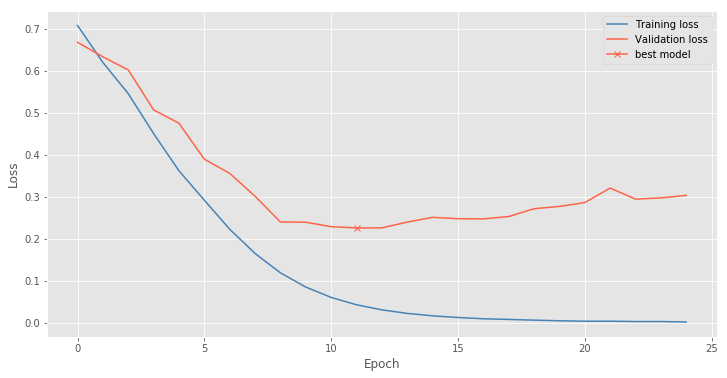

cnn_augmented
bestEpoch | bestAcc | bestValAcc :  21  |  0.9395253  |  0.9372905
minTrainLoss | minValLoss :  0.17278656836932646  |  0.18367238913444764


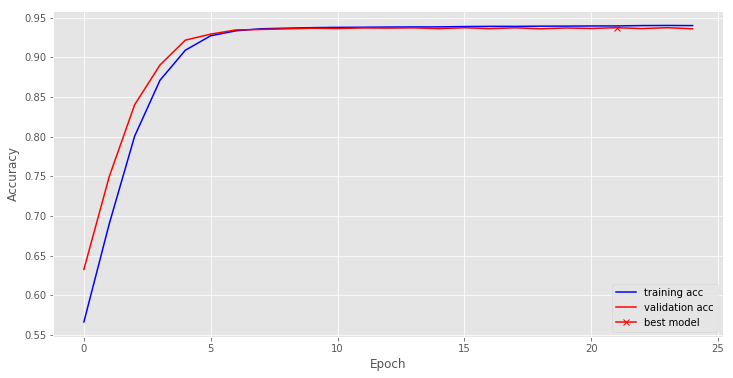

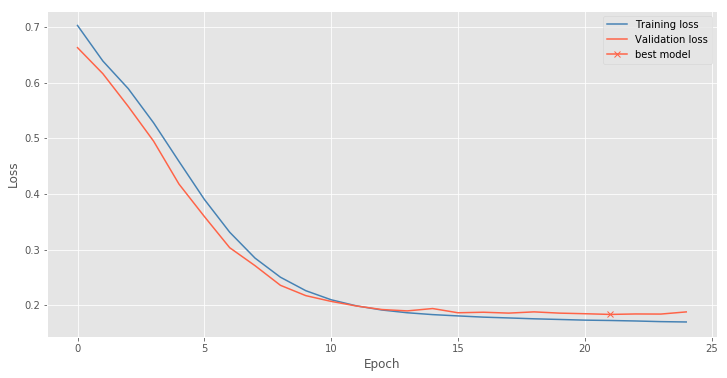

cnn_Augmented_do_0.2
bestEpoch | bestAcc | bestValAcc :  3  |  0.7313782  |  0.69294053
minTrainLoss | minValLoss :  0.5744453254271288  |  1.3618102895751016


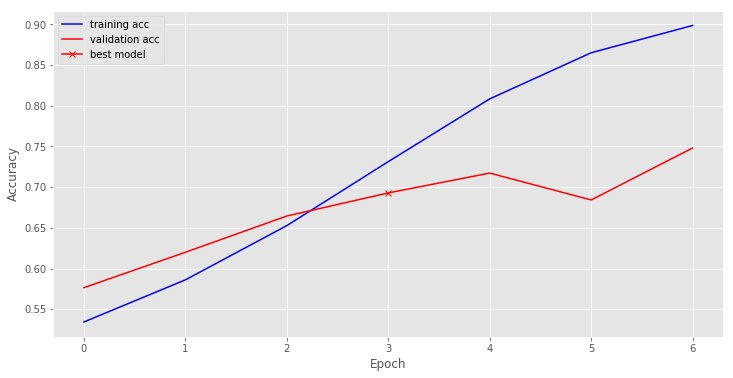

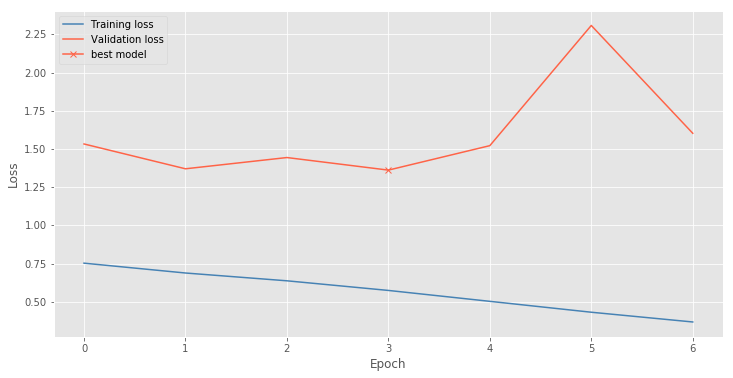

cnn_Augmented_do_0.3
bestEpoch | bestAcc | bestValAcc :  7  |  0.9124168  |  0.9048582
minTrainLoss | minValLoss :  0.32343392292471784  |  0.5303747310432534


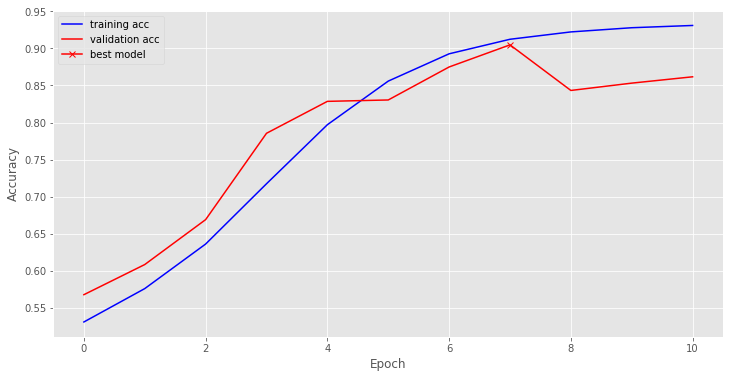

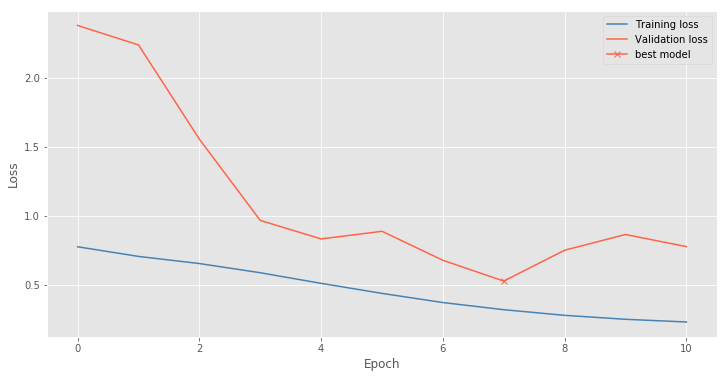

cnn_Augmented_do_0.4
bestEpoch | bestAcc | bestValAcc :  9  |  0.9245375  |  0.91264284
minTrainLoss | minValLoss :  0.2605279194331611  |  0.43654443965164086


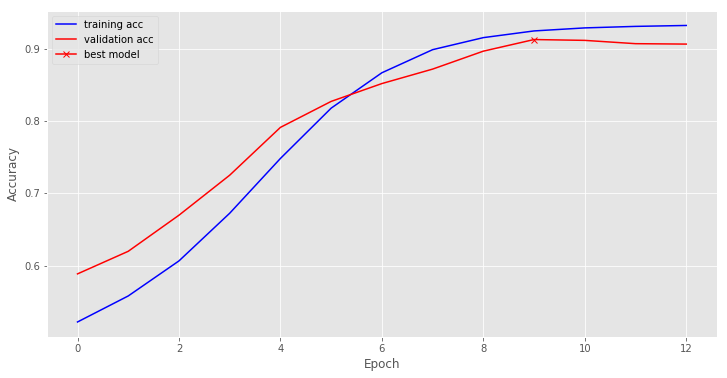

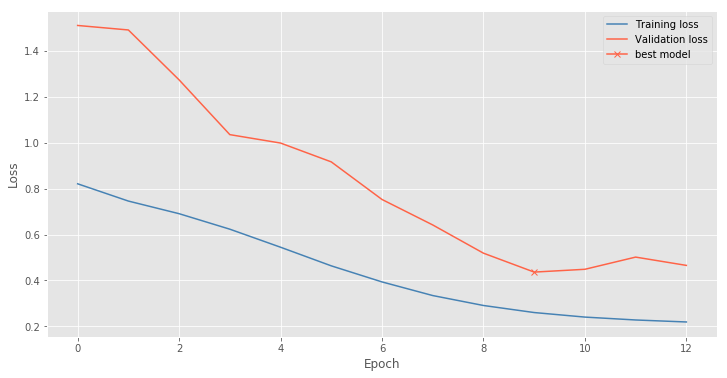

In [0]:
#plot all histories result saves
for k,v in histories.items():
    plotResult(v, k)

# Predict

Since transfer Learning provides better result, the prediction are done using the transfer learning model. 
Please refer to Ass Transfer Learning notebook forprediction code. 